<h1 style="font-size:40px;"><center>Exercise III:<br> Convolutional and Recurrent Neural Networks
</center></h1>

## Short summary
In this exercise you will: 

* Train CNNs for a binary classification problem
* Visualize how CNNs interprets the data
* Train CNNs for two 3-class classification problem
* Train a RNN on a time series prediction problem
* Visualize RNN hidden node activities

In this lab we will look at network architectures that are designed to handle specific kinds of data. Convolutional Neural Networks for image processing and Recurrent Neural Networks for time series processing

**Deadline for submitting the report: See Canvas assignment.**

## The data
Digits "5" and "6" from the MNIST database used for a binary classification problem.

A dataset consisting of circles, rectangles or triangles, that can be read using the *loadImagesCRT* function.

A dataset consisting of three different types of rectangles, squares, "horizontal" rectangles and "vertical" rectangles. This data can be read using the *loadImagesR3* function.

A dataset consisting of pairs of times series. The input time series is a train of rectangle pulses, and the output is triangles, i.e. an up-ramp followed by a down-ramp. For more details see the cell *Ex4-1*. The task is to train a recurrent network that predicts the triangle time series from the pulse time series.


## The exercises
As for the previous labs all exercises are found below.

## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | Data | Needed | Loading images for the CNN exercise |
| 3 | PlotImg | Information  | View some of the images |
| 4 | Stats | Needed | Compute classification results |
| 5 | Visualization | Needed | Visualize layers of a CNN |
| 6 | Ex1 | Exercise | For question 1-2 |
| 7 | Ex2 | Exercise | For question 3 |
| 8 | Ex3 | Exercise | For question 4-5 |
| 9 | Ex4-1 | Exercise | For question 6-9 |
| 10 | Ex4-2 | Exercise | For question 6-9 |
| 11 | Ex4-3 | Exercise | For question 6-9 |


In order for you to start with the exercise you need to run all cells with the CellType "Needed". The very first time you start with this exercise we suggest that you enter each of the needed cells, read the cell instruction and run the cell. It is important that you do this in the correct order, starting from the top and work you way down the cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" found in the "Cell" dropdown menu.

## Writing the report
First the report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a small introduction of what you have done in the lab.
* Answers to questions: For each of the questions provide an answer. It can be short answers or a longer ones depending on the nature of the questions, but try to be effective in your writing.
* Conclusion: Summarize your findings in a few sentences.

It is important that you write the report in this last cell and **not** after each question! 

## Last but not least
Have fun again!




### CellName: Init (#1)
### CellType: Needed
### Cell instruction: Initializing the libraries
In the cell below, we import all the libraries that are needed for this exercises. 

Run the cell by entering into the cell and press "CTRL Enter".


In [1]:
import numpy as np
import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Lambda, concatenate
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, RNN

from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
from tensorflow.keras import backend as K

from sklearn.metrics import *

import matplotlib
import matplotlib.pyplot as plt

### CellName: Data (#2)
### CellType: Needed
### Cell instruction: Function for getting images for the CNN exercises

This cell defines the functions that obtain the images needed for the CNN exercise. **Note**: Make sure the "crt-trn/" and "crt-tst/" folders are available in the same directory as this notebook file when you actually call these functions. Otherwise, the files files are not found.

Run the cell by entering into the cell and press "CTRL Enter".

In [2]:
def load_pics(folder,N):
    import imageio.v2 as imageio
    imgs = []
    for i in range(N):
        img = imageio.imread(folder+"img_{:05}.png".format(i+1))
        ch = img[:,:,0]
        imgs.append(ch)
    return np.array(imgs)

def load_labels(fn):
    return np.loadtxt(fn, usecols=(0,1,2))

def loadImagesCRT():
    base = "./"
    trainpic = load_pics(base + "crt-trn/", 500)
    valpic = load_pics(base + "crt-val/", 1000)
    ntrain, width, height = trainpic.shape

    xtrain = (trainpic/np.float32(255)).reshape(500, width, height, 1)
    xval = (valpic/np.float32(255)).reshape(1000, width, height, 1)

    ytrain = load_labels(base+"crt-trn_trg.csv")
    #ytrain = ytrain[:N]
    yval = load_labels(base+"crt-val_trg.csv")
    
    return xtrain, ytrain, xval, yval, width, height

def loadImagesR3():
    base = "./"
    trainpic = load_pics(base + "r3-trn/", 500)
    valpic = load_pics(base + "r3-val/", 1000)
    ntrain, width, height = trainpic.shape

    xtrain = (trainpic/np.float32(255)).reshape(500, width, height, 1)
    xval = (valpic/np.float32(255)).reshape(1000, width, height, 1)

    ytrain = load_labels(base+"r3-trn_trg.csv")
    #ytrain = ytrain[:500]
    yval = load_labels(base+"r3-val_trg.csv")

    return xtrain, ytrain, xval, yval, width, height


def loadMNIST56():
    xtrain, ytrain, xval, yval = np.load("mnist56.npy", allow_pickle=True)
    width, height = xtrain.shape[1:3]
    return xtrain, ytrain, xval, yval, width, height


### CellName: PlotImg (#3)
### CellType: Information
### Cell instruction: Show some of the images

Here we look at the first ten pictures in the training set, and their respective targets. You can select the dataset to look at by uncomment the correct line.

Run the cell by entering into the cell and press "CTRL Enter".

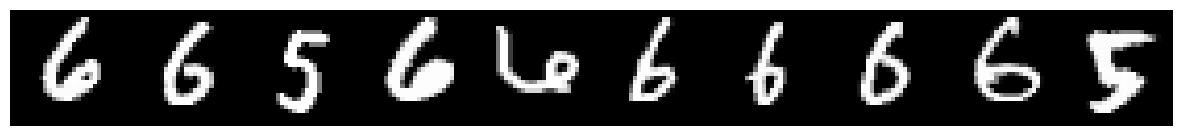

Targets:
[1. 1. 0. 1. 1. 1. 1. 1. 1. 0.]


In [3]:
xTrn, dTrn, xVal, dVal, width, height = loadMNIST56()
#xTrn, dTrn, xVal, dVal, width, height = loadImagesCRT()
#xTrn, dTrn, xVal, dVal, width, height = loadImagesR3()

rndSel = np.random.randint(500, size=10)
plt.figure(1, figsize=(15,10))
plt.imshow(xTrn[rndSel,:,:].swapaxes(0,1).reshape(width,10*height),cmap="gray")
plt.axis("off")
plt.show()

print("Targets:")
print(dTrn[rndSel])


### CellName: Stats (#4)
### CellType: Needed
### Cell instruction: Get binary and 3-class classification results

This cell just defines functions that we can call to compute som performance measures for binary and 3-class classification problems.

Run the cell by entering into the cell and press "CTRL Enter".

In [4]:
def binary_pred_stats(ytrue, ypred, threshold=0.5):
    one_correct = np.sum((ytrue==1)*(ypred > threshold))
    zero_correct = np.sum((ytrue==0)*(ypred <= threshold))
    sensitivity = one_correct / np.sum(ytrue==1)
    specificity = zero_correct / np.sum(ytrue==0)
    accuracy = (one_correct + zero_correct) / len(ytrue)
    return sensitivity, specificity, accuracy

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #plt.ylim([-0.5, cm.shape[0]-0.5])

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def multi_stat_3(model = None, x_test = None, y_test = None, lbl = None):
    y_pred = model.predict(x_test, verbose=0 )
    print(lbl,' log_loss:  ', log_loss(y_test, y_pred))

    y_true = y_test.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    print(lbl, ' accuracy:  ',(y_pred==y_true).mean(), '\n')

    target_names = ['class {}'.format(i+1) for i in range(3)]

    confuTst = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm           = confuTst, 
                          normalize    = False,
                          target_names = target_names,
                          title        = "Confusion Matrix: " + lbl)


### CellName: Visualization (#5)
### CellType: Needed
### Cell instruction: Function that can visualize the different layers of a CNN

This cell is feeding an image through a CNN and stores the intemediate values. It plots the different layers (filtered images) either before or after maxpooling.

Run the cell by entering into the cell and press "CTRL Enter".

In [5]:
def layerVisaliztion(model,
                     indata,
                     target,
                     idx=10,
                     post_pool = False):

    # The prediction for the test case
    #idx_pred = model.predict(indata)[idx,0]
    #print('True label: = {:0.1f}, Prediction = {:0.8f}'.format(idx_pred, target[idx]))
    
    print('Prediction: ', model.predict(indata, verbose=0)[idx])
    print('Target    : ', target[idx])
    
    kind = MaxPooling2D if post_pool else Conv2D
    outs = [l.output for l in model.layers if isinstance(l, kind)]
    intermediate = K.function([model.layers[0].input], outs)
    
    states = [indata[idx:idx+1]] + intermediate([indata[idx:idx+1]])
    plt.figure(figsize=(18,12))                    
    for k,s in enumerate(states):
        plt.figure(figsize=(18,12))
        plt.subplot(len(outs)+1,1,k+1)
        pics = s[0]
        pics = np.rollaxis(pics,2,0)
        rows = 2 if pics.shape[0] > 8 else 1
        cols = pics.shape[0]//rows
        pad = pics.shape[0]-rows*cols
        if pad > 0:
            padding = np.zeros_like(pics, shape=(rows-pad,)+pics.shape[1:])
            pics = np.concatenate([pics, padding])
            cols = cols + 1            
        imgshape = pics.shape[1:]
        pics = pics.reshape((rows,cols)+imgshape)
        pics = pics.swapaxes(1,2)
        pics = pics.reshape((pics.shape[0]*pics.shape[1], pics.shape[2]*pics.shape[3]))
        extent = (0,cols*imgshape[0], 0,rows*imgshape[1])
        plt.imshow(pics,cmap='gray',extent=extent)
        for r in range(1,rows):
            plt.plot([0,cols*imgshape[0]], [r*imgshape[1], r*imgshape[1]], color='r', linestyle='-', linewidth=1)
        for c in range(1,cols):
            plt.plot([c*imgshape[0], c*imgshape[0]], [0,rows*imgshape[1]], color='r', linestyle='-', linewidth=1)


### CellName: Ex1 (#6)
### CellType: Exercise
### Cell instruction: Instructions for question 1-2

## CNN for image classification

In this first exercise you are going to train a CNN that can separate between numbers "5" and "6" from the mnist dataset (mnist56 dataset). We are going to use 2000 training images and 1850 validation images. To start with we have a proposed CNN that can solve this problem. It consists of the following:
* First convolutional layer consisting of 4 kernels of size 3x3, with ReLU activation
* Maxpooling of size 2x2
* Second convolutional layer of 4 kernels of size 3x3, with ReLU activation
* Maxpooling of size 2x2
* Special layer *Flatten()*, just transforms the all of the max pooled filter outputs to a linear vector of outputs
* *Dense* layer, meaning a fully connected MLP layer, to 10 hidden nodes, again ReLU activation
* Final output layer consisting of one single output node with sigmoid activation function because we have a binary classification problem.

The default is to use *stride* = 1 and no *padding*. 

#### Question 1
Make sure you understand the definition of the CNN model in the cell below and train it. **What is your validation set performance in terms of the accuracy?**

#### Question 2
This image classification problem should be relatively easy since a "5" has some distinct differences from a "6". Experiment with the architecture of the CNN model and try to make it smaller (in terms of the number of trainable parameters), but with the same almost perfect validation accuracy (>98%). **How many parameters do you have in your trimmed model? What is your architecture?**

**Hint:** There is of course very many ways you can make a smaller architecture. You do not need to test all of them!


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 3)         30        
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 3)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 3)         84        
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 5, 3)           0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 75)                0         
                                                                 
 dense_6 (Dense)             (None, 5)                

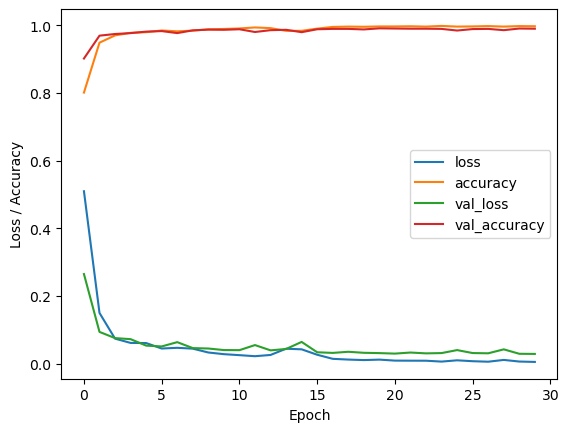

training: Accuracy = 0.9990, Sensitivity = 0.9990, Specificity = 0.9990 

validation: Accuracy = 0.9903, Sensitivity = 0.9896, Specificity = 0.9910 



In [28]:
# Load the dataset, MNIST-56
x_trn, d_trn, x_val, d_val, width, height = loadMNIST56()

# The size of the images
input_shape = (width, height, 1)

# Define the CNN ex1
ex1 = Sequential()

# First conv layer
ex1.add(Conv2D(3, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
ex1.add(MaxPooling2D(pool_size=(2, 2)))

# Second conv layer
ex1.add(Conv2D(3, kernel_size=(3, 3), activation='relu'))
ex1.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected MLP layers
ex1.add(Flatten())
ex1.add(Dense(5, activation='relu'))

# Output layer
ex1.add(Dense(1, activation='sigmoid'))

# We use cross entropy error and the adam optimizer
adam = Adam(learning_rate=0.005)
ex1.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
ex1.summary()

# Now train the ex1
estimator_ex1 = ex1.fit(x_trn, d_trn, 
                        validation_data=(x_val, d_val),
                        epochs=30, 
                        batch_size=64,
                        verbose=0)


# Training history
plt.figure()
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')
for k in estimator_ex1.history.keys():
    plt.plot(estimator_ex1.history[k], label = k) 
plt.legend(loc='best')
plt.show()

# Get the training predictions and results for those
d_trn_pred = ex1.predict(x_trn, verbose=0)[:,0]
sens, spec, acc = binary_pred_stats(d_trn, d_trn_pred)
print('training: Accuracy = {:.4f}, Sensitivity = {:.4f}, Specificity = {:.4f}'.format(acc, sens, spec), '\n')

# Get the validation predictions and the results for those
d_val_pred = ex1.predict(x_val, verbose=0)[:,0]
sens, spec, acc = binary_pred_stats(d_val, d_val_pred)
print('validation: Accuracy = {:.4f}, Sensitivity = {:.4f}, Specificity = {:.4f}'.format(acc, sens, spec), '\n')


### CellName: Ex2 (#7)
### CellType: Exercise
### Cell instruction: Instructions for question 3

You are now going to take a look into the CNN model. There are many attempts to visualize how the CNN model is making classifications. We will here just look at the different layer outputs given an input image. The function 'layerVisualization', found in cell #5 does the following:
* Use one selected image from the supplied dataset.
* Make a forward pass through the CNN remembering all intermediate values.
* Plot all of the "filters" for each of the layers.
* One can select to plot before or after the MaxPooling.

You pass the model that you want to visualize to the 'layerVisualization' function. If you do not change the names in cell (Ex1) it will be 'ex1'.

#### Question 3
Train a CNN for the "5" vs "6" problem! As a suggestion use the following CNN

*3x(3x3 kernel)-maxpool-3x(3x3 kernel)-maxpool-(Flatten)-Dense(5)-Dense(1)*

Make sure that your trained model gives good validation results (i.e. > 95% accuracy). Having such a model, you can run the cell below. There are two parameters you need to specify, *idx* and *post_pool*. The *post_pool* variable can be set to *True* meaning that filters will be shown after MaxPooling. The image to show is selected by the *idx* variable. As an example, the following values represent,
* idx=1 number "6"
* idx=2 number "5"
* idx=3 another number "6"
* idx=5 antoher number "5"

**Can you find and describe some property in the filters that makes sense when it comes to separating "5" from "6"?**

Hint! If you repeat the training you most likely get a new network and other filters!


Prediction:  [2.0315071e-12]
Target    :  0.0


<Figure size 1800x1200 with 0 Axes>

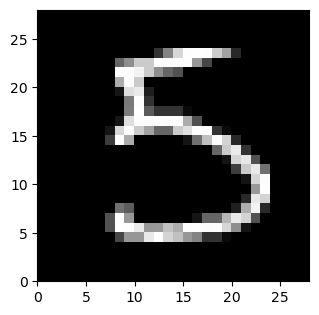

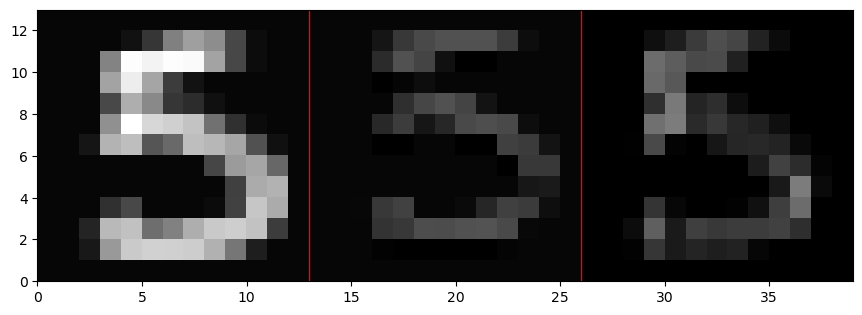

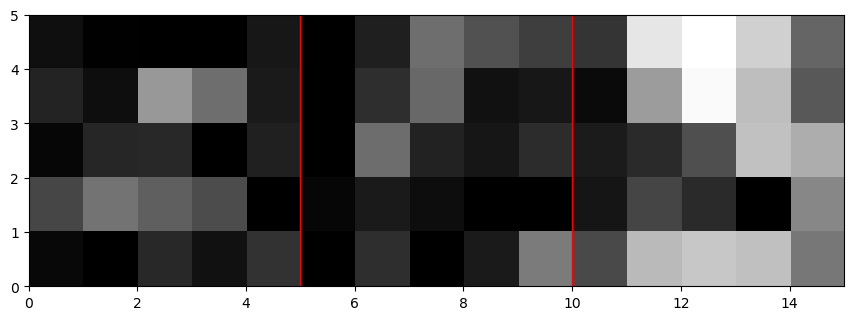

In [38]:
# Show before or after MaxPooling
post_pool = True

# The test image to look at
idx = 2

# Call the visualization method, giving the model and the validation data to select the case from
layerVisaliztion(ex1, x_val, d_val, idx, post_pool)

### CellName: Ex3 (#8)
### CellType: Exercise
### Cell instruction: Instructions for question 4-5

## CNN for image classification

In this exercise you are going to train a CNN that can separate between circles/squares/triangles found in the CRT dataset, and the three different types of rectangles found in the R3 dataset. You will use 500 training images and 1000 validation images. Code is provided for loading the data, training the model and presenting the result. Your task is to define the actual CNN model and see how it performs. For the following two questions you can optimize the model based on the validation performance. Here we assume that 1000 validation images are many enough for "model selection overtraining bias" to be small.

#### Question 4
Define your own CNN model for classifying the images in the CRT data into three classes. **Provide the details of your CNN model and present the validation result.**

**Hint:** Remember the difference between a binary classifier and a multi-class classifier!


#### Question 5
Define your own CNN model for classifying the images in the R3 data into three classes. **Provide the details of your CNN model and present the validation result.** **Why is this a more difficult problem than Question 4?**


#### Bonus task 
The bonus tasks are provided if you have extra time and want to continue to explore the CNNs. **These tasks are not required for the course and does not influence any grading**. 

You can use the *layerVisualization* method also for above models (Q4 and Q5). It will show you the different filter outputs. Again try to understand the features the different filter learn to separate between circles-triangles-rectangles, or the rectangles for the R3 data set.

Training data input shape:  (500, 64, 64, 1)
Training data output shape:  (500, 3)
Validation data input shape:  (1000, 64, 64, 1)
Validation data output shape:  (1000, 3)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_131 (Conv2D)         (None, 62, 62, 10)        100       
                                                                 
 max_pooling2d_101 (MaxPool  (None, 31, 31, 10)        0         
 ing2D)                                                          
                                                                 
 conv2d_132 (Conv2D)         (None, 29, 29, 10)        910       
                                                                 
 max_pooling2d_102 (MaxPool  (None, 14, 14, 10)        0         
 ing2D)                                                          
                                                                 
 conv2d_133 (

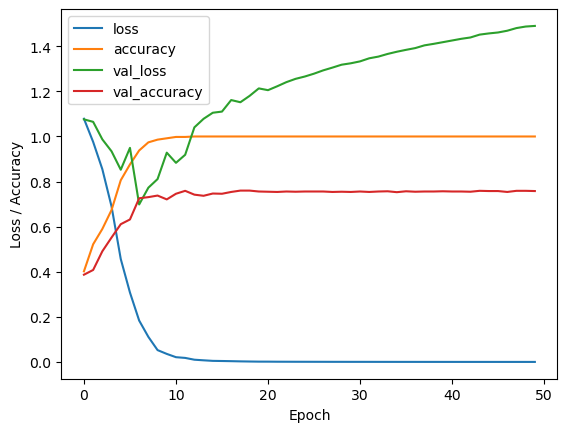

Training  log_loss:   0.00015077798080366658
Training  accuracy:   1.0 



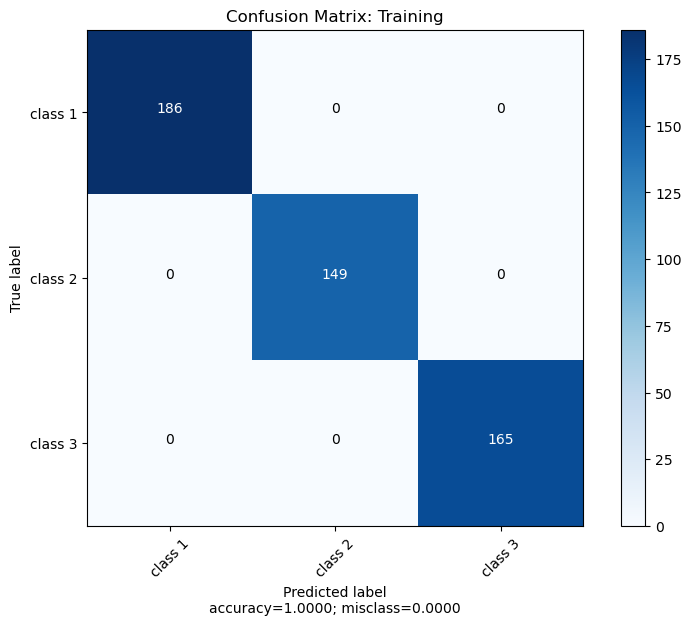

Validation  log_loss:   1.4784200543069865
Validation  accuracy:   0.758 



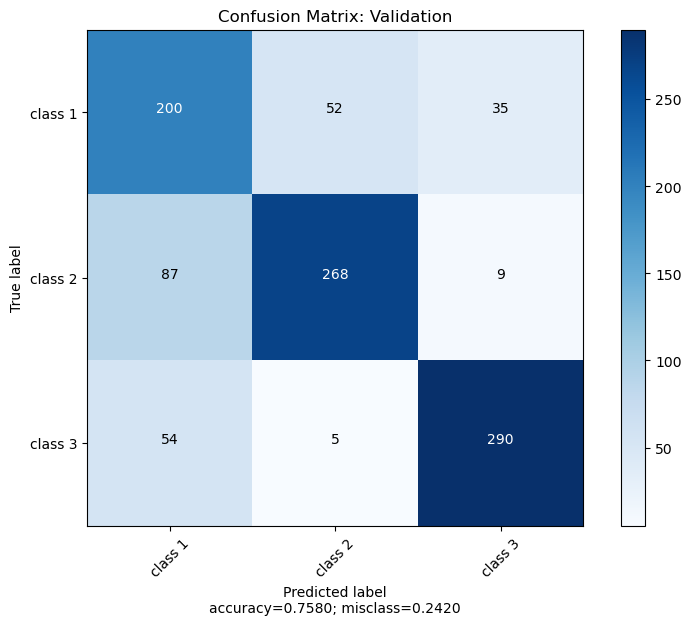

In [117]:
# Load the CRT dataset (Question 4)
# x_trn, d_trn, x_val, d_val, width, height = loadImagesCRT()

# Load the R3 dataset (Question 5)
x_trn, d_trn, x_val, d_val, width, height = loadImagesR3()

print('Training data input shape: ', x_trn.shape)
print('Training data output shape: ', d_trn.shape)
print('Validation data input shape: ', x_val.shape)
print('Validation data output shape: ', d_val.shape)

# The size of the images
input_shape = (width, height, 1)

# Define the CNN ex3
ex3 = Sequential()

# First layer
ex3.add(Conv2D(10, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
ex3.add(MaxPooling2D(pool_size=(2,2)))

# Second layer
ex3.add(Conv2D(10, kernel_size=(3, 3), activation='relu'))
ex3.add(MaxPooling2D(pool_size=(2,2)))

# Third layer, no pooling to preserve more detail for the dense layer.
ex3.add(Conv2D(10, kernel_size=(3, 3), activation='relu'))

# Fully connected MLP layers
ex3.add(Flatten())
ex3.add(Dense(16, activation='relu'))

# Output layer
ex3.add(Dense(3, activation='softmax'))

# We use cross entropy error and the adam optimizer
adam = Adam(learning_rate=0.003)
ex3.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
ex3.summary()

# Now train the ex3
estimator_ex3 = ex3.fit(x_trn, d_trn, 
                      validation_data=(x_val, d_val),
                      epochs=50, 
                      batch_size=50,
                      verbose=0)

# Training history
plt.figure()
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')
for k in estimator_ex3.history.keys():
    plt.plot(estimator_ex3.history[k], label = k) 
plt.legend(loc='best')
plt.show()

# Training result
multi_stat_3(ex3, x_trn, d_trn, 'Training')

# Validation result
multi_stat_3(ex3, x_val, d_val, 'Validation')

Prediction:  [9.7732067e-01 2.2679122e-02 2.1314978e-07]
Target    :  [0. 1. 0.]


<Figure size 1800x1200 with 0 Axes>

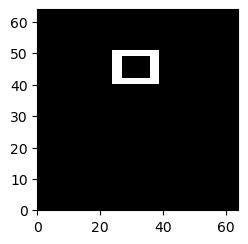

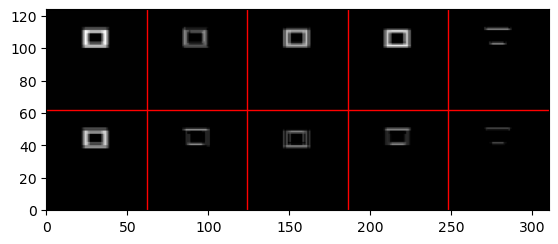

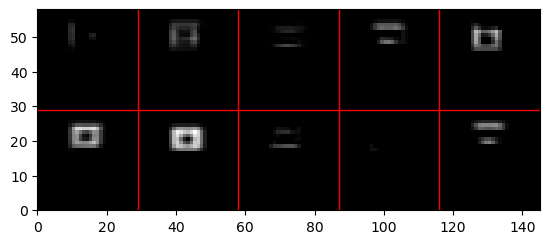

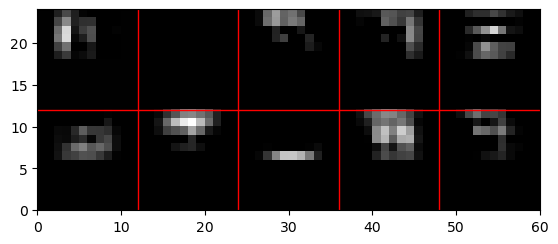

In [118]:
# Show before or after MaxPooling
post_pool = False

# The test image to look at
idx = 6

# Call the visualization method, giving the model and the test data to select the case from
layerVisaliztion(ex3, x_val, d_val, idx, post_pool)

### CellName: Ex4-1 (#9)
### CellType: Exercise
### Cell instruction: Instructions for question 6-9

## RNN as a pulse converter
We will now look at recurrent networks! **Note**: This exercise is divided into three cells. The actual questions for this part can be found in cell *Ex4-3* below.

### Loading and visualizing the data
The cell below loads the training data and the validation data from existing binary python files and plots one set of training/validation data, both the input sequence and the target sequence. Run the cell by entering into the cell and press "CTRL Enter".

How is data generated? The input sequence consists of square pulses with varying length and height. The waiting time between the pulses is also varying within some predefined ranges. The lower limit is 2 times the length of the previous pulse. The target triangle pulse sequence is built from the input sequence as follows:
* the triangle pulse starts when the input square pulse have ended.
* the width of the triangle (at the base) is twice the width of the square pulse.
* the height of the triangle is the same as the height of the square pulse.

The task is now to learn this mapping using a recurrent neural network. There are 500 input/target sequences in the training data and 500 in the validation data.


In [ ]:
# Load data from files
x_trn,d_trn= np.load("pulsedata1-trn.npy")
x_val,d_val = np.load("pulsedata1-val.npy")


print('Training data input shape: ', x_trn.shape)
print('Training data output shape: ', d_trn.shape)
print('Validation data input shape: ', x_val.shape)
print('Validation data output shape: ', d_val.shape)

# If this is set to True, then we have the reverse problem. Input triangle pulse, target square puls.
if False:
    d_trn,x_trn = x_trn[:,::-1],d_trn[:,::-1]
    d_val,x_val = x_val[:,::-1],d_val[:,::-1]

ns,tlen = x_trn.shape
t = np.arange(tlen)

# The training / test case to look at
i = 3

# Plot
plt.figure(figsize=(15,10))
plt.subplot(4,1,1)
plt.plot(t,x_trn[i,:])
plt.legend(['Training, input sequence'], loc=0)

plt.subplot(4,1,2)
plt.plot(t,d_trn[i,:])
plt.legend(['Training, target sequence'], loc=0)

plt.subplot(4,1,3)
plt.plot(t,x_val[i,:])
plt.legend(['Validation, input sequence'], loc=0)

plt.subplot(4,1,4)
plt.plot(t,d_val[i,:])
plt.legend(['Validation, target sequence'], loc=0)


### CellName: Ex4-2 (#10)
### CellType: Exercise
### Cell instruction: Instructions for question 6-9

## RNN as a pulse converter
### Define the model and train
Here we are going to setup the model and train it. There are three different models to choose from: 
* SimpleRNN: Simple feedback weights where the output from a node is feeding back to itself. For several hidden nodes there are feedback weights to all other nodes in the layer.
* LSTM: The LSTM unit
* GRU: The GRU unit

The standard choice of activation function is *tanh*, but you can also test *relu*. When it comes to training this model we are going to use a possible truncated BPTT approach. The support in Keras for doing this is somewhat limited so here it is implemented manually. In short we have 500 training sequences and we define a mini-batch size *mb* that selects *mb* of these sequences to train using the normal stochastic gradient descent idea. Then we have a variable *batchlen* that is the length of the sequence to use in truncated BPTT. The default values for these are *mb=20* and *batchlen=50*. If you want to train without the truncated BPTT approach put *batchlen=100*.

During training we print the normalized training and validation error. Normalized means here that the loss (=MSE) is divided by the variance of the target signal. That means that a normalized error of 1 is poor, but below 0.1 (or so) the error is much smaller than the signal itself.

What you need to do in this cell is to define your model and train it.

In [ ]:
%%time
ns,tlen = x_trn.shape

# Parameters defining the mini-batch size and 
# the sequence length for truncated BPTT
mb = 20
batchlen = 50

# The network type
net = SimpleRNN
#net = GRU
#net = LSTM

# Number of hidden nodes
nh1 = 5

# This is only if you would like to add an additional hidden layer. See below.
nh2 = 5

# The activation function
activation = 'tanh'
#activation = 'relu'

# The number of epochs
nE = 20

# Start defining the model
nmb = ns//mb
ntsteps = tlen//batchlen

model = Sequential()
model.add(net(nh1, 
              batch_input_shape=(mb,batchlen,1), 
              stateful=True, 
              return_sequences=True, 
              activation=activation))

# Uncomment this line if you want to add an additional hidden layer
#model.add(net(nh2, stateful=True, return_sequences=True, activation=activation))

model.add(TimeDistributed(Dense(1)))

adam = Adam(learning_rate=0.003)
model.compile(optimizer=adam,loss='mean_squared_error')
model.summary()

# Now the training part
trnTrgVar = np.var(d_trn[:,:])   # Variance for train target signal
valTrgVar = np.var(d_val[:,:])   # Variance for validation target signal
ndone = 0

print('Epoch', 'Time/Epoch', ' Trn-Err', '    Val-Err')
for ne in range(nE):
    t0 = time.time()
    sumlossTrn = 0
    for batch in range(nmb):
        i1,i2 = batch*mb,(batch+1)*mb
        model.reset_states()
        for tstep in range(ntsteps):
            t1,t2 = tstep*batchlen,(tstep+1)*batchlen
            loss = model.train_on_batch(x_trn[i1:i2,t1:t2,None], d_trn[i1:i2,t1:t2,None])
            sumlossTrn += loss
    meanlossTrn = sumlossTrn/(nmb*ntsteps)

    # Validation error
    sumlossVal = 0
    for batch in range(nmb):
        i1,i2 = batch*mb,(batch+1)*mb
        model.reset_states()
        for tstep in range(ntsteps):
            t1,t2 = tstep*batchlen,(tstep+1)*batchlen
            loss = model.evaluate(x_val[i1:i2,t1:t2,None], d_val[i1:i2,t1:t2,None],batch_size=mb,verbose=0)
            sumlossVal += loss
    meanlossVal = sumlossVal/(nmb*ntsteps)
    t1 = time.time()
    ndone += 1
    print(ndone, "    {:.2f}        {:.5f}     {:.5f}".format(t1-t0, meanlossTrn/trnTrgVar, meanlossVal/valTrgVar))


### CellName: Ex4-3 (#11)
### CellType: Exercise
### Cell instruction: Instructions for question 6-9

## RNN as a pulse converter
### Plot the result
In this cell we just plot the result for one of the first *mb* (minibatch size) test sequences. You can select which of these ones by an index (see the code). Also, the last graph shows the hidden node activation for all of the hidden nodes. **Note:** For the GRU and simpleRNN models this is all of the hidden activity there is, but for the LSTM there is also the memory signal. That one is not shown!

### Questions
We are now finally at the point of asking questions. Whenever you define a new model and train it, you need to run the  cell below in order to show the result for the newly trained model. 

**Hint!** For all of the questions below you are going to train different models. Keep an eye on how the training error is developing. If you see large fluctuations, you may to change the learning rate. The default value of 0.003 should be OK for most trainings. 

#### Question 6
(Just to get started!) Define a simpleRNN model with 5 hidden nodes and train it for about 20 epochs. **What validation error do you obtain?** 

Hint 1: The validation error can be found during "training" as the error for the last epoch.<br>
Hint 2: You may have to train a couple of times to make sure that you did not end up in a "bad" local minima the first time.

#### Question 7
Test different models! Train the three different models (one hidden layer only) with the approximately the same number of trainable weights (around 150-200) and decide which of them that works best? **So, out of the three different models, *simpleRNN, GRU* and *LSTM*, which one worked best using the same number weights?**

#### Question 8
Interpretation! You are now going to interpret the hidden node outputs. Remember that the actual output for each time is a linear combination of the hidden node outputs. As said before you can see the hidden nodes output in the last plot. Note that the weights in the dense layer can have different signs so that hidden nodes outputs can be linearly combined with both positive and negatives signs. Train a *GRU* model with 3 hidden nodes for about 20 epochs. **Try to explain what the different hidden nodes are detecting**.

Comment: This is of course a question with no definite true answer. We just want you to interpret what the different nodes are doing.

#### Question 9
If you look at the top of cell *Ex4-1* you can, by changing False -> True, define the reverse problem (see top of the code cell). That is, input is the triangle pulse and target is the square pulse. This should be a more difficult problem! **Why?** **Present a RNN model that can "solve" this reverse problem (i.e. below 0.1 in test error).**

Hint: Here you can experiment with two hidden layers of LSTM/GRU/SimpleRNN nodes


In [ ]:
xshow = x_val[:mb]
dshow = d_val[:mb]
dout = np.zeros((mb,tlen))
hidden1 = np.zeros((mb,tlen,nh1))
hidden2 = np.zeros((mb,tlen,nh2))

rnn1 = model.layers[0]
rnn2= model.layers[1]

#dense = model.layers[-1]
#sign = K.sign(dense.layer.kernel)[None,None,:,0]
if len(model.layers) > 2 :
    intermediate = K.function([rnn1.input], [rnn1.output, rnn2.output ])
else :
    intermediate = K.function([rnn1.input], [rnn1.output])

for tstep in range(ntsteps):
    t1,t2 = tstep*batchlen,(tstep+1)*batchlen
    inp = xshow[:,t1:t2,None]
    if len(model.layers) > 2 :
        hi,hi2 = intermediate([inp])
        hidden2[:,t1:t2:,:] = hi2
    else :
        hi, = intermediate([inp])
    hidden1[:,t1:t2:,:] = hi
    yi = model.predict(xshow[:,t1:t2,None], verbose=0)
    dout[:,t1:t2] = yi[:,:,0]

t = np.arange(tlen)

# Selection of validation sequence, valid range is [0,mb]
i = 0

plt.figure(figsize=(15,10))

plt.subplot(4,1,1)
plt.plot(t,xshow[i],'-',marker='.')
plt.legend(['Test, input sequence'], loc=0)

plt.subplot(4,1,2)
plt.plot(t,dshow[i],'-',marker='.')
plt.plot(t,dout[i],'-',marker='.')
plt.legend(['Test, target sequnce', 'Test, predicted sequence'], loc=0)

plt.subplot(4,1,3)
plt.plot(t,hidden1[i],'-',marker='.')
plt.title('Hidden 1 node outputs')

if len(model.layers) > 2 :
    plt.subplot(4,1,4)
    plt.plot(t,hidden2[i],'-',marker='.')
    plt.title('Hidden 2 node outputs')

# The report!
We have added intructions inside this report template. As you write your report, remove the instructions.

## Name
Theodor Anderberg Törngren

## Introduction
A few sentences about the overall theme of the exercise.

## Answers to questions
Provide enough information to clarify the meaning of your answers, so that they can be understood by someone who does not scroll up and read the entire instruction.

The questions are repeated here, for clarity of what is demanded. If it does not fit your style to quote them verbatim, change the format.

#### Question 1
What is your validation set performance in terms of the accuracy?

The validation performance is displayed in the following table: 

| Accuracy | Sensitivity | Specificity |
|----------|-------------|-------------|
| 0.9941   | 0.9916      | 0.9966      |

#### Question 2
How many parameters do you have in your trimmed model? What is your architecture?

The trimmed model is described by the following lines of code: 

~~~
# Define the CNN ex1
ex1 = Sequential()

# First conv layer
ex1.add(Conv2D(3, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
ex1.add(MaxPooling2D(pool_size=(2, 2)))

# Second conv layer
ex1.add(Conv2D(2, kernel_size=(3, 3), activation='relu'))
ex1.add(MaxPooling2D(pool_size=(2, 2)))

# Third conv layer
ex1.add(Conv2D(2, kernel_size=(3, 3), activation='relu'))
ex1.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected MLP layers
ex1.add(Flatten())
ex1.add(Dense(8, activation='relu'))

# Output layer
ex1.add(Dense(1, activation='sigmoid'))
~~~

This model has 157 trainable parameters, compared to the 1209 trainable parameters in the first model. The validation results for the trimmed model are presented in the following table. 

| Accuracy | Sensitivity | Specificity |
|----------|-------------|-------------|
| 0.9838   | 0.9791      | 0.9888      |

These results are comparable with the first model, but require less than a seventh of the number of trainable parameters.

#### Question 3
Can you find and describe some property in the filters that makes sense when it comes to separating "5" from "6"?

The filters vary depending on which model is used, and it also depends on the training of the model. Some observations that can be made are the following: 

Some filters seem create a negative image of the input, this can probably be used in order to determine if the input is a "5" or "6" due to their differing presence of pixels with high values in the lower left region. 

Other filters seem to enhance sharp turns and corners in the image, this seems logical, due to "5" usually being written with sharper turns than "6".   

#### Question 4
Provide the details of your CNN model for the CRT problem and present the validation result.

In this problem, a model with three convolutional layers with max pooling performed well. The code for the model, as well as the validation performance is presented below: 

~~~
# Define the CNN ex3
ex3 = Sequential()

# First conv layer
ex3.add(Conv2D(3, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
ex3.add(MaxPooling2D(pool_size=(2, 2)))

# Second conv layer
ex3.add(Conv2D(3, kernel_size=(3, 3), activation='relu'))
ex3.add(MaxPooling2D(pool_size=(2, 2)))

# Third conv layer
ex3.add(Conv2D(3, kernel_size=(3, 3), activation='relu'))
ex3.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected MLP layers
ex3.add(Flatten())
ex3.add(Dense(15, activation='relu'))

# Output layer
ex3.add(Dense(3, activation='softmax'))
~~~

| Validation Accuracy | 
|-------|
| 0.978 |

#### Question 5
Provide the details of your CNN model for the R3 problem and present the validation result.<br>
Why is this a more difficult problem than Question 4?

In this problem, one layer of pooling was removed, and the size of the convolutional layers was increased in order to achieve an acceptable validation performance. The code for creating the network is presented below: 

```
# Define the CNN ex3
ex3 = Sequential()

# First layer
ex3.add(Conv2D(10, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
ex3.add(MaxPooling2D(pool_size=(2,2)))

# Second layer
ex3.add(Conv2D(10, kernel_size=(3, 3), activation='relu'))
ex3.add(MaxPooling2D(pool_size=(2,2)))

# Third layer, no pooling to preserve more detail for the dense layer.
ex3.add(Conv2D(10, kernel_size=(3, 3), activation='relu'))

# Fully connected MLP layers
ex3.add(Flatten())
ex3.add(Dense(16, activation='relu'))

# Output layer
ex3.add(Dense(3, activation='softmax'))
```

The average validation performance of this model during three runs is presented in the following table: 

| Validation Accuracy | 
|-------|
| 0.813 |

This is significantly less than what a more simple model achieved on the Q4 dataset, which indicates that this problem is more difficult. This seems reasonable due to the rectangle and square shapes being more similar, only being distinguished by their proportions. 

#### Question 6
What validation error do you obtain?

#### Question 7
Present three different models, *simpleRNN, GRU* and *LSTM*, using roughly the same number weights.<br>
Which one worked best?

#### Question 8
Try to explain what the different hidden nodes are detecting. *Comment: This is of course a question with no definite true answer. We just want you to interpret what the different nodes are doing.*

#### Question 9
Why is the reverse of the pulse problem (input signal and target signal change roles, time is reversed) more difficult? <br>
Present a RNN model that can "solve" this reverse problem (i.e. below 0.1 in test error).


## Summary
Connect the summary to your introduction, to provide a brief overview of your findings.
